In [2]:
# Minimal, clean setup
!pip -q uninstall -y neurom  # avoid conflicts
!pip -q install morphio

import os, re, io, shutil, gzip
import numpy as np
import pandas as pd
import morphio
import matplotlib.pyplot as plt
from collections import deque

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00


In [3]:
from google.colab import files

uploaded = files.upload()  # pick one or many .swc files

# Save uploads to disk with clean filenames
swc_paths = []
for raw_name, content in uploaded.items():
    name = os.path.basename(raw_name).strip()

    # fix weird endings like ".swc)" -> ".swc"
    name = re.sub(r'\)\s*$', '', name)

    # if extension missing, force .swc
    if not name.lower().endswith((".swc", ".asc", ".h5", ".swc.gz")):
        name = name + ".swc"

    # handle gz if needed
    if name.lower().endswith(".swc.gz"):
        with gzip.open(io.BytesIO(content), "rb") as gz, open(name[:-3], "wb") as f:
            f.write(gz.read())
        path = name[:-3]
    else:
        with open(name, "wb") as f:
            f.write(content)
        path = name

    swc_paths.append(path)

swc_paths = sorted(list(dict.fromkeys(swc_paths)))
print("Saved files:", swc_paths)

# quick load check
for p in swc_paths:
    morphio.Morphology(p)
print("Load check OK.")

Saving 2964_B_3-2-B.CNG.swc to 2964_B_3-2-B.CNG.swc
Saved files: ['2964_B_3-2-B.CNG.swc']
Load check OK.


In [4]:
import os
from collections import deque
import numpy as np
import pandas as pd
import morphio

# (2) params
DENDRITES_ONLY = True   # set False if you want axon + dendrites
EPS = 1e-6              # epsilon for “exactly on a radius” handling
SHOLL_STEP = 10.0       # µm

# (3) helpers
def segment_lengths_from_section(sec):
    pts = np.asarray(sec.points, dtype=float)
    if len(pts) < 2:
        return []
    return list(np.linalg.norm(pts[1:] - pts[:-1], axis=1))

def iter_dendritic_roots(nrn):
    for root in nrn.root_sections:
        if DENDRITES_ONLY and root.type == morphio.SectionType.axon:
            continue
        yield root

def keep_section(sec):
    return not (DENDRITES_ONLY and sec.type == morphio.SectionType.axon)

# (4) gather .swc in working dir (includes those saved in Cell 2)
all_swcs = sorted([n for n in os.listdir() if n.lower().endswith(".swc")])
assert all_swcs, "No .swc files found. Upload in Cell 2."

# (5) feature extraction
rows = []
os.makedirs("sholl_curves", exist_ok=True)

for path in all_swcs:
    try:
        neuron = morphio.Morphology(path)
    except Exception as e:
        print(f"Skipping {path} (failed to read): {e}")
        continue

    # collect sections (respect DENDRITES_ONLY)
    sections = []
    for root in iter_dendritic_roots(neuron):
        stack = [root]
        while stack:
            s = stack.pop()
            if not keep_section(s):
                continue
            sections.append(s)
            stack.extend(s.children)

    # first pass: segment stats + counts + max extent
    seg_lengths, n_tips, n_bifurc, max_depth = [], 0, 0, 0
    soma_center = np.array(neuron.soma.center, dtype=float)
    max_radial_extent = 0.0

    for root in iter_dendritic_roots(neuron):
        stack = deque([(root, 0)])
        while stack:
            sec, depth = stack.pop()
            if not keep_section(sec):
                continue
            # lengths
            seg_lengths.extend(segment_lengths_from_section(sec))
            # depth & counts
            max_depth = max(max_depth, depth)
            if len(sec.children) == 0:
                n_tips += 1
            if len(sec.children) >= 2:
                n_bifurc += 1
            # extent
            pts = np.asarray(sec.points, dtype=float)
            if pts.size:
                d = np.linalg.norm(pts - soma_center, axis=1)
                if d.size:
                    m = float(np.max(d))
                    if m > max_radial_extent:
                        max_radial_extent = m
            for ch in sec.children:
                stack.append((ch, depth+1))

    total_len = float(np.sum(seg_lengths)) if seg_lengths else 0.0
    n_segments = int(len(seg_lengths))
    mean_len = float(np.mean(seg_lengths)) if seg_lengths else 0.0
    std_len  = float(np.std(seg_lengths))  if seg_lengths else 0.0

    # second pass: Sholl with dynamic radii (0..ceil(max_extent)+step)
    if max_radial_extent <= 0:
        radii = np.arange(SHOLL_STEP, SHOLL_STEP + SHOLL_STEP, SHOLL_STEP, dtype=float)
    else:
        Rmax = float(np.ceil(max_radial_extent + SHOLL_STEP))
        radii = np.arange(SHOLL_STEP, Rmax + SHOLL_STEP/2, SHOLL_STEP, dtype=float)

    sholl = np.zeros_like(radii, dtype=int)

    for sec in sections:
        pts = np.asarray(sec.points, dtype=float)
        if len(pts) < 2:
            continue
        d = np.linalg.norm(pts - soma_center, axis=1)

        for i in range(len(pts)-1):
            d1, d2 = d[i], d[i+1]
            # sign-change ⇒ definite crossing
            s1 = np.sign(d1 - radii)
            s2 = np.sign(d2 - radii)
            sign_change = (s1 * s2) < 0

            # endpoints exactly on a radius: count once if the other end is strictly across
            close1 = np.isclose(d1, radii, atol=EPS)
            close2 = np.isclose(d2, radii, atol=EPS)
            touches = close1 | close2
            touches_both = close1 & close2  # rare; ignore to avoid double count
            opposite_side = (d1 < radii) ^ (d2 < radii)

            sholl += (sign_change | (touches & ~touches_both & opposite_side)).astype(int)

    peak_idx = int(np.argmax(sholl)) if len(sholl) else 0
    sholl_peak = int(sholl[peak_idx]) if len(sholl) else 0
    sholl_peak_radius = float(radii[peak_idx]) if len(radii) else 0.0
    sholl_auc = int(sholl.sum())  # optional scalar summary

    # optional derived rates (cheap, helpful)
    bif_per_100um = (100.0 * n_bifurc / total_len) if total_len > 0 else np.nan
    tips_per_100um = (100.0 * n_tips / total_len) if total_len > 0 else np.nan

    rows.append({
        "file_name": path,
        "dendrites_only": int(DENDRITES_ONLY),
        "total_length_um": total_len,
        "num_segments": n_segments,
        "mean_segment_length_um": mean_len,
        "std_segment_length_um": std_len,
        "n_bifurcations": int(n_bifurc),
        "n_tips": int(n_tips),
        "max_tree_depth": int(max_depth),
        "sholl_peak": sholl_peak,
        "sholl_peak_radius_um": sholl_peak_radius,
        "sholl_auc": sholl_auc,  # new
        "max_radial_extent_um": float(max_radial_extent),
        "bif_per_100um": bif_per_100um,  # optional
        "tips_per_100um": tips_per_100um # optional
    })

    # save per-cell Sholl curve
    base = os.path.splitext(os.path.basename(path))[0]
    pd.DataFrame({"radius_um": radii, "intersections": sholl}).to_csv(
        f"sholl_curves/{base}_sholl.csv", index=False
    )

# (6) write a consistent CSV (fixed column order)
COLS = [
    "file_name","dendrites_only","total_length_um","num_segments",
    "mean_segment_length_um","std_segment_length_um",
    "n_bifurcations","n_tips","max_tree_depth",
    "sholl_peak","sholl_peak_radius_um","sholl_auc","max_radial_extent_um",
    "bif_per_100um","tips_per_100um"
]
df = pd.DataFrame(rows)[COLS]
df.to_csv("raw_features.csv", index=False)
print(f"Wrote raw_features.csv with {len(df)} rows.")
df.head()


Wrote raw_features.csv with 1 rows.


,file_name,dendrites_only,total_length_um,num_segments,mean_segment_length_um,std_segment_length_um,n_bifurcations,n_tips,max_tree_depth,sholl_peak,sholl_peak_radius_um,sholl_auc,max_radial_extent_um,bif_per_100um,tips_per_100um
0,2964_B_3-2-B.CNG.swc,1,1843.467463,670,2.751444,1.878139,30,34,7,22,40.0,135,152.491904,1.627368,1.84435


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_name               1 non-null      object 
 1   dendrites_only          1 non-null      int64  
 2   total_length_um         1 non-null      float64
 3   num_segments            1 non-null      int64  
 4   mean_segment_length_um  1 non-null      float64
 5   std_segment_length_um   1 non-null      float64
 6   n_bifurcations          1 non-null      int64  
 7   n_tips                  1 non-null      int64  
 8   max_tree_depth          1 non-null      int64  
 9   sholl_peak              1 non-null      int64  
 10  sholl_peak_radius_um    1 non-null      float64
 11  sholl_auc               1 non-null      int64  
 12  max_radial_extent_um    1 non-null      float64
 13  bif_per_100um           1 non-null      float64
 14  tips_per_100um          1 non-null      float6

In [6]:
import pandas as pd
import numpy as np

def print_neuron_summary(csv_path, name):
    df = pd.read_csv(csv_path, sep=None, engine="python")

    row = df.loc[df["file_name"].astype(str) == name]
    assert not row.empty, f"Neuron {name!r} not found in {csv_path}"
    if len(row) > 1:
        print(f"Warning: found {len(row)} rows for {name!r}; using the first.")
    row = row.iloc[0]

    # Pull values (with defaults if a column is missing)
    total_len = float(row.get("total_length_um", np.nan))
    n_bif     = int(row.get("n_bifurcations", np.nan))
    n_tips    = int(row.get("n_tips", np.nan))
    sholl_pk  = int(row.get("sholl_peak", np.nan))
    sholl_auc = float(row.get("sholl_auc", np.nan))
    max_rad   = float(row.get("max_radial_extent_um", np.nan))
    max_depth = int(row.get("max_tree_depth", np.nan))
    mean_seg  = float(row.get("mean_segment_length_um", np.nan))
    std_seg   = float(row.get("std_segment_length_um", np.nan))

    # Derived metrics
    bif_per_100um  = (100.0 * n_bif  / total_len) if total_len > 0 else np.nan
    tips_per_100um = (100.0 * n_tips / total_len) if total_len > 0 else np.nan

    # Report
    print(f"Neuron: {name}")
    print(f"Total length (µm):        {total_len:.6f}")
    print(f"# Bifurcations:            {n_bif:d}")
    print(f"# Tips:                    {n_tips:d}")
    print(f"Mean segment length (µm):  {mean_seg:.6f}")
    print(f"Std. segment length (µm):  {std_seg:.6f}")
    print(f"Max tree depth:            {max_depth:d}")
    print(f"Max radial extent (µm):    {max_rad:.6f}")
    print(f"Sholl peak:                {sholl_pk:d}")
    print(f"Sholl AUC (sum counts):    {sholl_auc:.0f}")
    print(f"Bifurcations / 100 µm:     {bif_per_100um:.6f}")
    print(f"Tips / 100 µm:             {tips_per_100um:.6f}")

print_neuron_summary("raw_features.csv", "2964_B_3-2-B.CNG.swc")


Neuron: 2964_B_3-2-B.CNG.swc
Total length (µm):        1843.467463
# Bifurcations:            30
# Tips:                    34
Mean segment length (µm):  2.751444
Std. segment length (µm):  1.878139
Max tree depth:            7
Max radial extent (µm):    152.491904
Sholl peak:                22
Sholl AUC (sum counts):    135
Bifurcations / 100 µm:     1.627368
Tips / 100 µm:             1.844350


In [7]:
import os
base = os.path.splitext("2964_B_3-2-B.CNG.swc")[0]
sholl_df = pd.read_csv(f"sholl_curves/{base}_sholl.csv")
print(sholl_df.head())


   radius_um  intersections
0       10.0              6
1       20.0             14
2       30.0             21
3       40.0             22
4       50.0             17


In [8]:
import pandas as pd
import numpy as np

def build_metric_summary(vals, name="(unnamed)"):
    label_lookup = {
        "total_length_um":         "Total length (µm)",
        "num_segments":            "# Segments",
        "mean_segment_length_um":  "Mean segment length (µm)",
        "std_segment_length_um":   "Std. segment length (µm)",
        "n_bifurcations":          "# Bifurcations",
        "n_tips":                  "# Tips",
        "max_tree_depth":          "Max tree depth",
        "max_radial_extent_um":    "Max radial extent (µm)",
        "sholl_peak":              "Sholl peak",
        "sholl_peak_radius_um":    "Sholl peak radius (µm)",
        "sholl_auc":               "Sholl AUC (sum)",
        "bif_per_100um":           "Bifurcations / 100 µm",
        "tips_per_100um":          "Tips / 100 µm",
    }

    # Accept dict or Series
    if isinstance(vals, dict):
        keys_from_vals = list(vals.keys())
        get_val = lambda k: vals.get(k, np.nan)
    elif isinstance(vals, pd.Series):
        keys_from_vals = list(vals.index)
        get_val = lambda k: vals.get(k, np.nan)  # .get avoids KeyError
    else:
        raise TypeError("`vals` must be a dict or pandas Series.")

    META_KEYS = {"file_name", "name", "path", "neuron_id", "dendrites_only"}

    # Preferred display order
    desired_order = [
        "total_length_um",
        "n_bifurcations",
        "n_tips",
        "bif_per_100um",
        "tips_per_100um",
        "mean_segment_length_um",
        "std_segment_length_um",
        "num_segments",
        "max_tree_depth",
        "max_radial_extent_um",
        "sholl_peak",
        "sholl_peak_radius_um",
        "sholl_auc",
    ]

    # Keep numeric-like keys (after coercion), excluding meta
    numeric_keys = []
    for k in keys_from_vals:
        if k in META_KEYS:
            continue
        v = pd.to_numeric(get_val(k), errors="coerce")
        if pd.notna(v):
            numeric_keys.append(k)

    # Respect desired order first, then any remaining numeric keys
    metric_keys = [k for k in desired_order if k in numeric_keys] + \
                  [k for k in numeric_keys if k not in desired_order]

    # Build table
    metric_labels = [label_lookup.get(k, k) for k in metric_keys]
    values = [pd.to_numeric(get_val(k), errors="coerce") for k in metric_keys]
    summary = pd.DataFrame({"metric": metric_keys, "label": metric_labels, "value": values})

    # Format: ints for counts/sums, 6dp otherwise
    int_like = {
        "n_bifurcations", "n_tips", "max_tree_depth",
        "num_segments", "sholl_peak", "sholl_auc"
    }
    summary["value"] = summary.apply(
        lambda row: (int(row["value"]) if pd.notna(row["value"]) and row["metric"] in int_like
                     else (np.nan if pd.isna(row["value"]) else round(float(row["value"]), 6))),
        axis=1
    )

    print(name)
    return summary


In [9]:
import pandas as pd

# Load your features table
df = pd.read_csv("raw_features.csv")

# Pick the neuron you want
name = "2964_B_3-2-B.CNG.swc"

# Get the row for that neuron
row = df.loc[df["file_name"] == name]
assert not row.empty, f"{name!r} not found in raw_features.csv"

# Keep the first match (there should be only one)
row = row.iloc[0]

# Pass it as a Series into the summary builder
vals = row  # or row.to_dict() if you want a dict
summary = build_metric_summary(vals, name)
display(summary)


2964_B_3-2-B.CNG.swc


,metric,label,value
0,total_length_um,Total length (µm),1843.467463
1,n_bifurcations,# Bifurcations,30.000000
2,n_tips,# Tips,34.000000
3,bif_per_100um,Bifurcations / 100 µm,1.627368
4,tips_per_100um,Tips / 100 µm,1.844350
5,mean_segment_length_um,Mean segment length (µm),2.751444
6,std_segment_length_um,Std. segment length (µm),1.878139
7,num_segments,# Segments,670.000000
8,max_tree_depth,Max tree depth,7.000000
9,max_radial_extent_um,Max radial extent (µm),152.491904


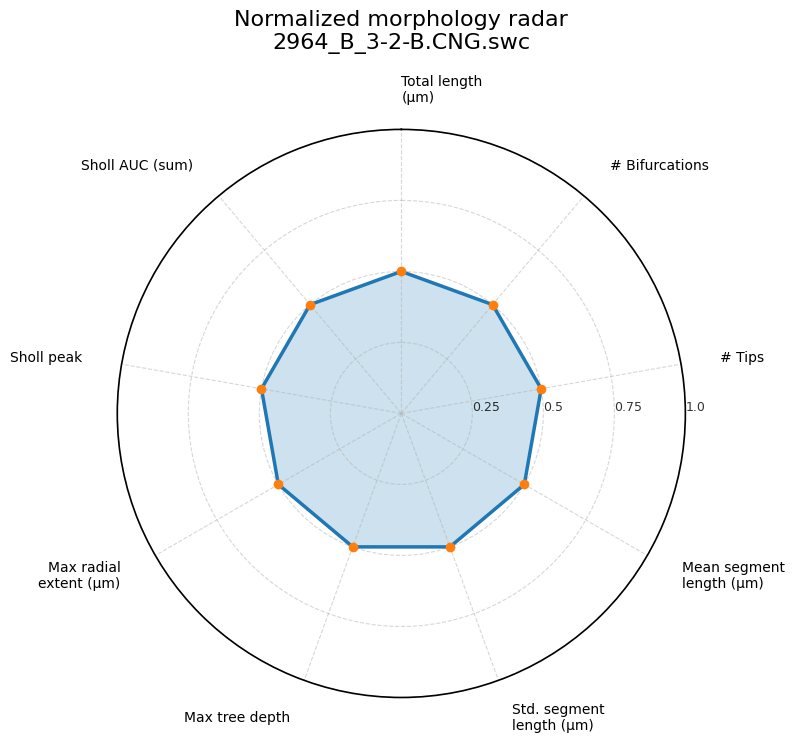

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# --- load data & pick neuron ---
df = pd.read_csv("raw_features.csv")
name = "2964_B_3-2-B.CNG.swc"
row = df.loc[df["file_name"] == name]
assert not row.empty, f"{name} not found"
row = row.iloc[0]
vals = row  # pandas Series

# --- choose which metrics to show on the radar ---
metrics = [
    "total_length_um",
    "n_bifurcations",
    "n_tips",
    "mean_segment_length_um",
    "std_segment_length_um",
    "max_tree_depth",
    "max_radial_extent_um",
    "sholl_peak",
    "sholl_auc",
]

# Pretty labels
label_lookup = {
    "total_length_um":         "Total length (µm)",
    "n_bifurcations":          "# Bifurcations",
    "n_tips":                  "# Tips",
    "mean_segment_length_um":  "Mean segment length (µm)",
    "std_segment_length_um":   "Std. segment length (µm)",
    "max_tree_depth":          "Max tree depth",
    "max_radial_extent_um":    "Max radial extent (µm)",
    "sholl_peak":              "Sholl peak",
    "sholl_auc":               "Sholl AUC (sum)",
}

# --- build normalization ranges from the dataset (robust & automatic) ---
def minmax_with_margin(series, margin=0.1):
    s = pd.to_numeric(series, errors="coerce").dropna()
    lo, hi = float(s.min()), float(s.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        # degenerate case: fallback around the single value
        v = float(s.iloc[0]) if len(s) else 1.0
        lo, hi = v*(1-margin), v*(1+margin)
    else:
        span = hi - lo
        lo -= span*margin
        hi += span*margin
    return lo, hi

ranges = {}
for m in metrics:
    if m in df.columns:
        ranges[m] = minmax_with_margin(df[m])
    else:
        # fallback: +-10% around current value
        v = float(pd.to_numeric(vals.get(m, np.nan), errors="coerce"))
        if not np.isfinite(v):
            v = 1.0
        ranges[m] = (v*0.9, v*1.1)

# --- filter to numeric & assemble values ---
def wrap(s, w=16):
    return "\n".join(textwrap.wrap(str(s), width=w, break_long_words=False))

metric_keys, labels, values_norm = [], [], []
for k in metrics:
    v = pd.to_numeric(vals.get(k, np.nan), errors="coerce")
    if pd.isna(v):
        continue
    lo, hi = ranges[k]
    z = float(np.clip((float(v) - lo) / max(hi - lo, 1e-12), 0.0, 1.0))
    metric_keys.append(k)
    labels.append(wrap(label_lookup.get(k, k)))
    values_norm.append(z)

assert values_norm, "No numeric metrics to plot."

# --- radar plot ---
angles = np.linspace(0, 2*np.pi, len(values_norm), endpoint=False)
values_c = values_norm + [values_norm[0]]
angles_c = np.concatenate([angles, [angles[0]]])

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)

ax.plot(angles_c, values_c, linewidth=2.5)
ax.fill(angles_c, values_c, alpha=0.22)
ax.scatter(angles, values_norm, s=36, zorder=5)

ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=10)
ax.tick_params(pad=6)
for label, ang in zip(ax.get_xticklabels(), angles):
    rot = 90 - np.degrees(ang)
    if rot < -90 or rot > 90:
        rot += 180; label.set_ha("right")
    else:
        label.set_ha("left")
    label.set_rotation(rot); label.set_rotation_mode("anchor")
    th, r = label.get_position(); label.set_position((th, r - 0.06))

ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25","0.5","0.75","1.0"], fontsize=9, alpha=0.8)
ax.set_rlabel_position(90)
ax.grid(True, linewidth=0.8, linestyle="--", alpha=0.5)
ax.spines["polar"].set_linewidth(1.2)
ax.set_title(f"Normalized morphology radar\n{name}", pad=58, fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 1.15])
plt.show()


Using SWC: 2964_B_3-2-B.CNG.swc


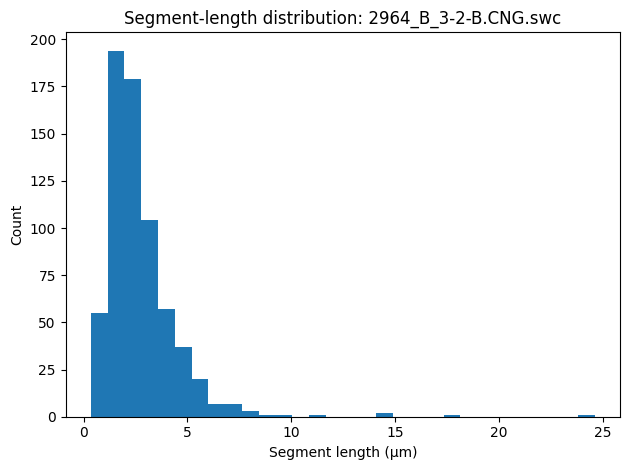


--- Morphometrics ---
         total_length_um: 1843.4674631479243
          n_bifurcations: 30
                  n_tips: 34
  mean_segment_length_um: 2.751443974847648
   std_segment_length_um: 1.8781388361254245
          max_tree_depth: 7
    max_radial_extent_um: 152.4919035746574
              sholl_peak: 22
               sholl_auc: 135


In [11]:
import os
from collections import deque
import morphio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DENDRITES_ONLY = True
EPS = 1e-6
SHOLL_STEP = 10.0  # µm

def features_from_swc(file_name, dendrites_only=True, plot_seg_hist=True):
    neuron = morphio.Morphology(file_name)

    def keep_section(sec):
        return not (dendrites_only and sec.type == morphio.SectionType.axon)

    # Gather all sections (respecting dendrites_only)
    sections = []
    for root in neuron.root_sections:
        if dendrites_only and root.type == morphio.SectionType.axon:
            continue
        stack = [root]
        while stack:
            s = stack.pop()
            if not keep_section(s):
                continue
            sections.append(s)
            stack.extend(s.children)

    # Pass 1: segment lengths, counts, depths, radial extent
    seg_lengths = []
    n_tips = n_bifs = max_depth = 0
    soma_center = np.array(neuron.soma.center, dtype=float)
    max_radial_extent = 0.0

    for root in neuron.root_sections:
        if dendrites_only and root.type == morphio.SectionType.axon:
            continue
        stack = deque([(root, 0)])
        while stack:
            sec, depth = stack.pop()
            if not keep_section(sec):
                continue
            pts = np.asarray(sec.points, dtype=float)
            if pts.shape[0] >= 2:
                diffs = pts[1:] - pts[:-1]
                seg_lengths.extend(np.linalg.norm(diffs, axis=1))
            # counts
            max_depth = max(max_depth, depth)
            if len(sec.children) == 0: n_tips += 1
            if len(sec.children) >= 2: n_bifs += 1
            # extent
            if pts.size:
                d = np.linalg.norm(pts - soma_center, axis=1)
                if d.size:
                    max_radial_extent = max(max_radial_extent, float(d.max()))
            for ch in sec.children:
                stack.append((ch, depth + 1))

    seg_lengths = np.asarray(seg_lengths, float)
    total_len = float(seg_lengths.sum()) if seg_lengths.size else 0.0
    num_segments = int(seg_lengths.size)
    mean_len = float(seg_lengths.mean()) if seg_lengths.size else 0.0
    std_len  = float(seg_lengths.std())  if seg_lengths.size else 0.0

    # Pass 2: Sholl (robust, dynamic radii)
    if max_radial_extent <= 0:
        radii = np.arange(SHOLL_STEP, SHOLL_STEP + SHOLL_STEP, SHOLL_STEP, dtype=float)
    else:
        Rmax = float(np.ceil(max_radial_extent + SHOLL_STEP))
        radii = np.arange(SHOLL_STEP, Rmax + SHOLL_STEP/2, SHOLL_STEP, dtype=float)

    sholl = np.zeros_like(radii, dtype=int)
    for sec in sections:
        pts = np.asarray(sec.points, dtype=float)
        if pts.shape[0] < 2:
            continue
        d = np.linalg.norm(pts - soma_center, axis=1)
        for i in range(len(pts) - 1):
            d1, d2 = d[i], d[i + 1]
            s1 = np.sign(d1 - radii)
            s2 = np.sign(d2 - radii)
            sign_change = (s1 * s2) < 0
            close1 = np.isclose(d1, radii, atol=EPS)
            close2 = np.isclose(d2, radii, atol=EPS)
            touches = close1 | close2
            touches_both = close1 & close2
            opposite = (d1 < radii) ^ (d2 < radii)
            sholl += (sign_change | (touches & ~touches_both & opposite)).astype(int)

    peak_idx = int(np.argmax(sholl)) if len(sholl) else 0
    sholl_peak = int(sholl[peak_idx]) if len(sholl) else 0
    sholl_peak_radius = float(radii[peak_idx]) if len(radii) else 0.0
    sholl_auc = int(sholl.sum())

    # Build vals dict for your tables/plots
    vals = {
        "file_name": os.path.basename(file_name),
        "dendrites_only": int(dendrites_only),
        "total_length_um": total_len,
        "num_segments": num_segments,
        "mean_segment_length_um": mean_len,
        "std_segment_length_um": std_len,
        "n_bifurcations": int(n_bifs),
        "n_tips": int(n_tips),
        "max_tree_depth": int(max_depth),
        "max_radial_extent_um": float(max_radial_extent),
        "sholl_peak": sholl_peak,
        "sholl_peak_radius_um": sholl_peak_radius,
        "sholl_auc": sholl_auc,
        "bif_per_100um": (100.0 * n_bifs / total_len) if total_len > 0 else np.nan,
        "tips_per_100um": (100.0 * n_tips / total_len) if total_len > 0 else np.nan,
    }

    # Optional: quick QC histogram
    if plot_seg_hist and num_segments > 0:
        plt.figure()
        plt.hist(seg_lengths, bins=30)
        plt.xlabel("Segment length (µm)")
        plt.ylabel("Count")
        plt.title(f"Segment-length distribution: {os.path.basename(file_name)}")
        plt.tight_layout()
        plt.show()

    sholl_df = pd.DataFrame({"radius_um": radii, "intersections": sholl})
    return vals, sholl_df

# --- Run on your file (from your logic above) ---
if os.path.exists("raw_features.csv"):
    df = pd.read_csv("raw_features.csv")
    file_name = df.loc[0, "file_name"]
else:
    swcs = sorted([f for f in os.listdir() if f.lower().endswith(".swc")])
    assert swcs, "No .swc files found."
    file_name = swcs[0]

print(f"Using SWC: {file_name}")
vals, sholl_df = features_from_swc(file_name, dendrites_only=DENDRITES_ONLY, plot_seg_hist=True)

# Pretty print a few
print("\n--- Morphometrics ---")
for k in ["total_length_um","n_bifurcations","n_tips","mean_segment_length_um",
          "std_segment_length_um","max_tree_depth","max_radial_extent_um","sholl_peak","sholl_auc"]:
    print(f"{k:>24}: {vals[k]}")


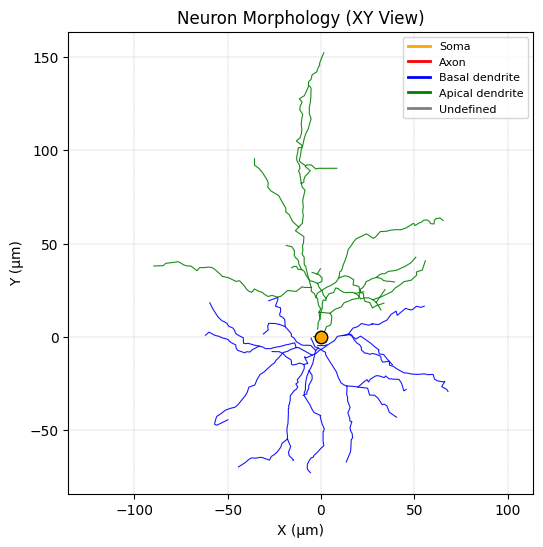

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import morphio

DENDRITES_ONLY = True  # match your feature-extraction mode

# color map for standard SWC types
type_colors = {
    morphio.SectionType.soma: "orange",
    morphio.SectionType.axon: "red",
    morphio.SectionType.basal_dendrite: "blue",
    morphio.SectionType.apical_dendrite: "green",
    morphio.SectionType.undefined: "gray"
}

plt.figure(figsize=(6, 6))

# plot each section with its neurite type color
for sec in neuron.root_sections:
    if DENDRITES_ONLY and sec.type == morphio.SectionType.axon:
        continue
    stack = [sec]
    while stack:
        s = stack.pop()
        if DENDRITES_ONLY and s.type == morphio.SectionType.axon:
            continue
        pts = np.array(s.points)
        color = type_colors.get(s.type, "gray")
        plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=0.8, alpha=0.9)
        stack.extend(s.children)

# plot soma center
soma_center = np.array(neuron.soma.center)
plt.scatter(soma_center[0], soma_center[1],
            color="orange", edgecolor="black", s=80, zorder=5, label="Soma")

plt.title("Neuron Morphology (XY View)")
plt.xlabel("X (µm)")
plt.ylabel("Y (µm)")
plt.axis("equal")
plt.grid(True, linestyle="--", linewidth=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="orange", lw=2, label="Soma"),
    Line2D([0], [0], color="red", lw=2, label="Axon"),
    Line2D([0], [0], color="blue", lw=2, label="Basal dendrite"),
    Line2D([0], [0], color="green", lw=2, label="Apical dendrite"),
    Line2D([0], [0], color="gray", lw=2, label="Undefined")
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=8)

plt.show()


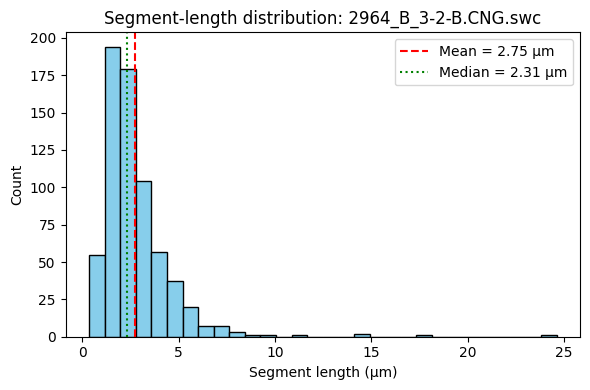

In [13]:
import os
import morphio
import numpy as np
import matplotlib.pyplot as plt

# --- Load SWC ---
file_name = "2964_B_3-2-B.CNG.swc"  # change if needed
neuron = morphio.Morphology(file_name)

# --- Collect sections (example: dendrites only) ---
DENDRITES_ONLY = True
sections = []
for root in neuron.root_sections:
    if DENDRITES_ONLY and root.type == morphio.SectionType.axon:
        continue
    stack = [root]
    while stack:
        s = stack.pop()
        if DENDRITES_ONLY and s.type == morphio.SectionType.axon:
            continue
        sections.append(s)
        stack.extend(s.children)

# --- Compute segment lengths ---
segment_lengths = []
for sec in sections:
    pts = np.asarray(sec.points, dtype=float)
    if pts.shape[0] >= 2:
        diffs = pts[1:] - pts[:-1]
        segment_lengths.extend(np.linalg.norm(diffs, axis=1))

segment_lengths = np.asarray(segment_lengths, dtype=float)

# --- Plot histogram if non-empty ---
if segment_lengths.size > 0:
    mean_len = np.mean(segment_lengths)
    median_len = np.median(segment_lengths)

    plt.figure(figsize=(6,4))
    plt.hist(segment_lengths, bins=30, color="skyblue", edgecolor="black")
    plt.axvline(mean_len, color="red", linestyle="--", label=f"Mean = {mean_len:.2f} µm")
    plt.axvline(median_len, color="green", linestyle=":", label=f"Median = {median_len:.2f} µm")
    plt.xlabel("Segment length (µm)")
    plt.ylabel("Count")
    plt.title(f"Segment-length distribution: {os.path.basename(file_name)}")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No segments found in this morphology.")


Sholl peak: 22 @ 40 µm
Sholl AUC (sum of counts): 135
Saved 2964_B_3-2-B.CNG_sholl.csv


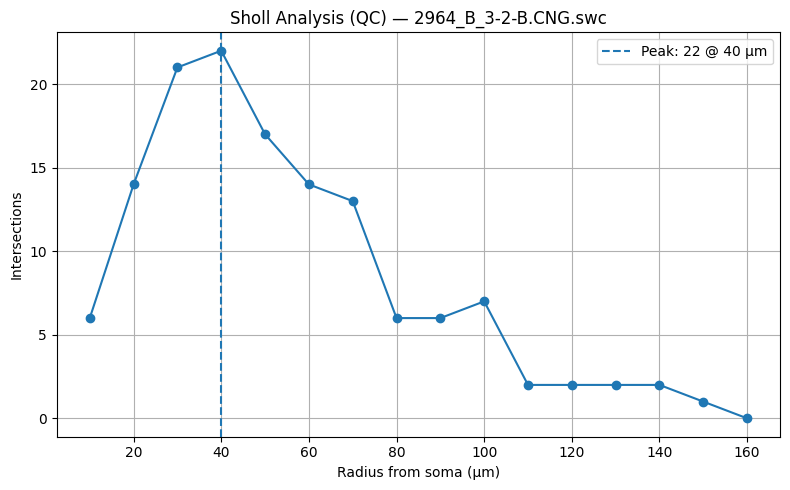

In [14]:
# QC: Sholl curve visualization (self-contained)
import os
import numpy as np
import matplotlib.pyplot as plt
import morphio
from collections import deque

# --- config ---
FILE_NAME = "2964_B_3-2-B.CNG.swc"   # change if needed
DENDRITES_ONLY = True
STEP_UM = 10.0
EPS = 1e-6
SAVE_CSV = True

# --- load neuron ---
neuron = morphio.Morphology(FILE_NAME)
soma_center = np.asarray(neuron.soma.center, dtype=float)

def keep_section(sec):
    return not (DENDRITES_ONLY and sec.type == morphio.SectionType.axon)

# --- gather sections (respect dendrites-only) ---
sections = []
for root in neuron.root_sections:
    if not keep_section(root):
        continue
    stack = [root]
    while stack:
        s = stack.pop()
        if not keep_section(s):
            continue
        sections.append(s)
        stack.extend(s.children)

# --- compute max radial extent first ---
max_radial_extent = 0.0
for s in sections:
    pts = np.asarray(s.points, dtype=float)
    if pts.size:
        d = np.linalg.norm(pts - soma_center, axis=1)
        if d.size:
            max_radial_extent = max(max_radial_extent, float(d.max()))

# --- radii grid (dynamic) ---
if max_radial_extent <= 0:
    RADII = np.arange(STEP_UM, STEP_UM + STEP_UM, STEP_UM)
else:
    Rmax = float(np.ceil(max_radial_extent + STEP_UM))
    RADII = np.arange(STEP_UM, Rmax + STEP_UM/2, STEP_UM)

def crossings_for_segment(d1, d2, radii, eps=EPS):
    s1 = np.sign(d1 - radii); s2 = np.sign(d2 - radii)
    sign_change = (s1 * s2) < 0
    close1 = np.isclose(d1, radii, atol=eps); close2 = np.isclose(d2, radii, atol=eps)
    touches = close1 | close2
    touches_both = close1 & close2  # degenerate: segment exactly along the sphere; ignore
    opposite_side = (d1 < radii) ^ (d2 < radii)
    return (sign_change | (touches & ~touches_both & opposite_side)).astype(int)

# --- accumulate crossings ---
sholl_counts = np.zeros_like(RADII, dtype=int)
for sec in sections:
    pts = np.asarray(sec.points, dtype=float)
    if len(pts) < 2:
        continue
    d = np.linalg.norm(pts - soma_center, axis=1)
    for i in range(len(pts) - 1):
        sholl_counts += crossings_for_segment(d[i], d[i+1], RADII)

# --- simple stats ---
peak_idx = int(np.argmax(sholl_counts)) if sholl_counts.size else 0
sholl_peak = int(sholl_counts[peak_idx]) if sholl_counts.size else 0
sholl_peak_radius = float(RADII[peak_idx]) if RADII.size else 0.0
sholl_auc = int(sholl_counts.sum())

print(f"Sholl peak: {sholl_peak} @ {sholl_peak_radius:.0f} µm")
print(f"Sholl AUC (sum of counts): {sholl_auc}")

# --- optional: save CSV ---
if SAVE_CSV:
    base = os.path.splitext(os.path.basename(FILE_NAME))[0]
    out = f"{base}_sholl.csv"
    import pandas as pd
    pd.DataFrame({"radius_um": RADII, "intersections": sholl_counts}).to_csv(out, index=False)
    print(f"Saved {out}")

# --- plot ---
plt.figure(figsize=(8, 5))
plt.plot(RADII, sholl_counts, marker="o")
if sholl_counts.size and sholl_counts.max() > 0:
    plt.axvline(sholl_peak_radius, linestyle="--",
                label=f"Peak: {sholl_peak} @ {sholl_peak_radius:.0f} µm")
plt.title(f"Sholl Analysis (QC) — {os.path.basename(FILE_NAME)}")
plt.xlabel("Radius from soma (µm)")
plt.ylabel("Intersections")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


compartment                apical    basal
total_length_um          1004.684  838.783
num_segments              322.000  348.000
mean_segment_length_um      3.120    2.410
std_segment_length_um       2.323    1.248
n_bifurcations             17.000   13.000
n_tips                     18.000   16.000
max_tree_depth              7.000    3.000
mean_terminal_path_um     113.637   74.113
median_terminal_path_um    99.256   75.739
p95_terminal_path_um      203.574  105.424
max_radial_extent_um      152.492   89.268
sholl_peak                 11.000   12.000
sholl_peak_radius_um       40.000   20.000
sholl_auc                  69.000   66.000


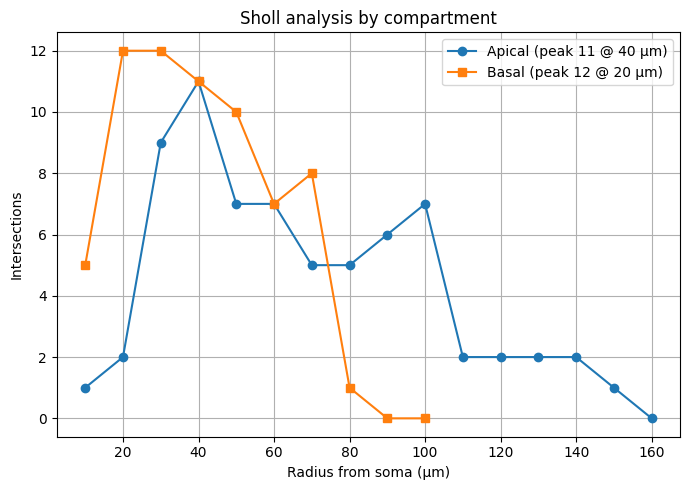

In [15]:
import morphio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

# -------- params --------
FILE = "2964_B_3-2-B.CNG.swc"
EPS = 1e-6
SHOLL_STEP = 10.0  # µm

# -------- load --------
neuron = morphio.Morphology(FILE)
soma_center = np.asarray(neuron.soma.center, dtype=float)

# -------- helpers --------
def seg_lengths(pts):
    if len(pts) < 2:
        return np.array([], dtype=float)
    return np.linalg.norm(np.diff(pts, axis=0), axis=1)

def crossings_for_segment(d1, d2, radii, eps=EPS):
    s1 = np.sign(d1 - radii)
    s2 = np.sign(d2 - radii)
    sign_change = (s1 * s2) < 0
    close1 = np.isclose(d1, radii, atol=eps)
    close2 = np.isclose(d2, radii, atol=eps)
    touches = close1 | close2
    touches_both = close1 & close2
    opposite_side = (d1 < radii) ^ (d2 < radii)
    return (sign_change | (touches & ~touches_both & opposite_side)).astype(int)

def collect_sections_by_type(neuron, sec_type):
    """Return all sections belonging to neurites whose ROOT is sec_type."""
    sections = []
    roots = [r for r in neuron.root_sections if r.type == sec_type]
    for root in roots:
        stack = [root]
        while stack:
            s = stack.pop()
            sections.append(s)
            stack.extend(s.children)
    return sections, roots

def metrics_for(neuron, sec_type):
    sections, roots = collect_sections_by_type(neuron, sec_type)
    if not sections:
        return {  # graceful empty result
            "sections": [],
            "total_length_um": 0.0,
            "num_segments": 0,
            "mean_segment_length_um": 0.0,
            "std_segment_length_um": 0.0,
            "n_bifurcations": 0,
            "n_tips": 0,
            "max_tree_depth": 0,
            "mean_terminal_path_um": 0.0,
            "median_terminal_path_um": 0.0,
            "p95_terminal_path_um": 0.0,
            "max_radial_extent_um": 0.0,
            "sholl": np.zeros(1, dtype=int),
            "radii": np.array([SHOLL_STEP], dtype=float),
            "sholl_peak": 0,
            "sholl_peak_radius_um": 0.0,
            "sholl_auc": 0
        }

    # pass 1: lengths, counts, depths, extent
    total_len = 0.0
    num_segments = 0
    n_tips = 0
    n_bifurc = 0
    max_depth = 0
    terminal_paths = []
    max_radial_extent = 0.0

    # precompute extent
    for s in sections:
        pts = np.asarray(s.points, dtype=float)
        if pts.size:
            d = np.linalg.norm(pts - soma_center, axis=1)
            if d.size:
                max_radial_extent = max(max_radial_extent, float(d.max()))

    # geodesic path lengths from soma
    for root in roots:
        root_pts = np.asarray(root.points, dtype=float)
        root_len = float(np.sum(seg_lengths(root_pts)))
        stack = deque([(root, 0, root_len)])
        while stack:
            sec, depth, path_len_to_here = stack.pop()
            max_depth = max(max_depth, depth)

            pts = np.asarray(sec.points, dtype=float)
            segs = seg_lengths(pts)
            total_len += float(np.sum(segs))
            num_segments += int(segs.size)

            nchild = len(sec.children)
            if nchild == 0:
                n_tips += 1
                terminal_paths.append(path_len_to_here)
            elif nchild >= 2:
                n_bifurc += 1

            for ch in sec.children:
                ch_pts = np.asarray(ch.points, dtype=float)
                stack.append((ch, depth + 1, path_len_to_here + float(np.sum(seg_lengths(ch_pts)))))

    # segment stats
    if num_segments > 0:
        seg_all = []
        for s in sections:
            seg_all.extend(seg_lengths(np.asarray(s.points, dtype=float)))
        seg_all = np.asarray(seg_all, dtype=float)
        mean_seg = float(np.mean(seg_all)) if seg_all.size else 0.0
        std_seg  = float(np.std(seg_all))  if seg_all.size else 0.0
    else:
        mean_seg = std_seg = 0.0

    # dynamic radii for Sholl
    if max_radial_extent <= 0:
        RADII = np.arange(SHOLL_STEP, SHOLL_STEP + SHOLL_STEP, SHOLL_STEP, dtype=float)
    else:
        Rmax = float(np.ceil(max_radial_extent + SHOLL_STEP))
        RADII = np.arange(SHOLL_STEP, Rmax + SHOLL_STEP/2, SHOLL_STEP, dtype=float)

    sholl = np.zeros_like(RADII, dtype=int)
    for sec in sections:
        pts = np.asarray(sec.points, dtype=float)
        if len(pts) < 2:
            continue
        d = np.linalg.norm(pts - soma_center, axis=1)
        for i in range(len(pts) - 1):
            sholl += crossings_for_segment(d[i], d[i + 1], RADII)

    peak_idx = int(np.argmax(sholl)) if sholl.size else 0
    return {
        "sections": sections,
        "total_length_um": total_len,
        "num_segments": num_segments,
        "mean_segment_length_um": mean_seg,
        "std_segment_length_um": std_seg,
        "n_bifurcations": n_bifurc,
        "n_tips": n_tips,
        "max_tree_depth": max_depth,
        "mean_terminal_path_um": float(np.mean(terminal_paths)) if terminal_paths else 0.0,
        "median_terminal_path_um": float(np.median(terminal_paths)) if terminal_paths else 0.0,
        "p95_terminal_path_um": float(np.percentile(terminal_paths, 95)) if terminal_paths else 0.0,
        "max_radial_extent_um": max_radial_extent,
        "sholl": sholl,
        "radii": RADII,
        "sholl_peak": int(sholl[peak_idx]) if sholl.size else 0,
        "sholl_peak_radius_um": float(RADII[peak_idx]) if RADII.size else 0.0,
        "sholl_auc": int(sholl.sum())
    }

# -------- compute per-compartment --------
apical = metrics_for(neuron, morphio.SectionType.apical_dendrite)
basal  = metrics_for(neuron, morphio.SectionType.basal_dendrite)

# -------- table --------
rows = []
for name, m in [("apical", apical), ("basal", basal)]:
    rows.append({
        "compartment": name,
        "total_length_um": m["total_length_um"],
        "num_segments": m["num_segments"],
        "mean_segment_length_um": m["mean_segment_length_um"],
        "std_segment_length_um": m["std_segment_length_um"],
        "n_bifurcations": m["n_bifurcations"],
        "n_tips": m["n_tips"],
        "max_tree_depth": m["max_tree_depth"],
        "mean_terminal_path_um": m["mean_terminal_path_um"],
        "median_terminal_path_um": m["median_terminal_path_um"],
        "p95_terminal_path_um": m["p95_terminal_path_um"],
        "max_radial_extent_um": m["max_radial_extent_um"],
        "sholl_peak": m["sholl_peak"],
        "sholl_peak_radius_um": m["sholl_peak_radius_um"],
        "sholl_auc": m["sholl_auc"],
    })
df_comp = pd.DataFrame(rows).set_index("compartment")
with pd.option_context("display.precision", 3):
    print(df_comp.T)

# -------- plot: Sholl overlay --------
plt.figure(figsize=(7,5))
if apical["sections"]:
    plt.plot(apical["radii"], apical["sholl"], marker="o",
             label=f"Apical (peak {apical['sholl_peak']} @ {apical['sholl_peak_radius_um']:.0f} µm)")
if basal["sections"]:
    plt.plot(basal["radii"], basal["sholl"], marker="s",
             label=f"Basal (peak {basal['sholl_peak']} @ {basal['sholl_peak_radius_um']:.0f} µm)")
plt.xlabel("Radius from soma (µm)")
plt.ylabel("Intersections")
plt.title("Sholl analysis by compartment")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from pathlib import Path
import pandas as pd
import json

raw_features_path = "/mnt/data/raw_features.csv"
sholl_csv_path = "2964_B_3-2-B.CNG_sholl.csv"

# Fallback: use extracted numbers from memory if raw_features.csv not found
if Path(raw_features_path).exists():
    df = pd.read_csv(raw_features_path)
    row = df.iloc[0]
    total_length_um = row["total_length_um"]
    n_bifurcations = row["n_bifurcations"]
    n_tips = row["n_tips"]
    max_tree_depth = row["max_tree_depth"]
    max_radial_extent_um = row["max_radial_extent_um"]
else:
    total_length_um = 1843.467463
    n_bifurcations = 30
    n_tips = 34
    max_tree_depth = 7
    max_radial_extent_um = 152.491904

# Load Sholl data from CSV
sholl_df = pd.read_csv(sholl_csv_path)
radii = sholl_df["radius_um"].tolist()
counts = sholl_df["intersections"].tolist()

# Build target dict
target_features = {
    "total_length_um": total_length_um,
    "n_bifurcations": int(n_bifurcations),
    "n_tips": int(n_tips),
    "max_tree_depth": int(max_tree_depth),
    "max_radial_extent_um": max_radial_extent_um,
    "sholl": {
        "radii_um": radii,
        "counts": counts
    }
}

# Save JSON
target_path = "target.json"
with open(target_path, "w") as f:
    json.dump(target_features, f, indent=2)

print(f"Saved {target_path}")


Saved target.json
